In [1]:
import gc
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier #분류
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from mlxtend.classifier import StackingCVClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [1]:
# pip install seaborn

     |████████████████████████████████| 292 kB 29.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install xgboost

     |████████████████████████████████| 173.6 MB 16 kB/s               
Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install lightgbm

     |████████████████████████████████| 2.0 MB 28.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install catboost

     |████████████████████████████████| 76.6 MB 44 kB/s              
     |████████████████████████████████| 15.2 MB 69.3 MB/s            
     |████████████████████████████████| 46 kB 6.0 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [2]:
SEED = 37
PROBAS = True
FOLDS = 5
N_ESTIMATORS = 1000
TARGET = 'Y_Class'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) # Seed 고정

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [5]:
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [6]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 이후 LINE과 product_code를 label encoding 해줍니다

In [7]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


# 학습을 하기위해  train값 test값으로 나누어줍니다 
# test_size는 0.15로 해야 결과값이 좋았다고 얘기해주면 좋을것같습니다

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.15, random_state = 37)
print (f'X_train:{X_train.shape} y_train: {y_train.shape}')
print (f'X_test:{X_test.shape} y_test: {y_test.shape}')

X_train:(508, 2877) y_train: (508,)
X_test:(90, 2877) y_test: (90,)


# 보시면 밑에 lgb_params, rf_params를 맞춰주기도 했는데
# 기본값을 사용하는게 더 잘나와서 cl2,cl3,cl4를 보시면 사용하지 않을것을 볼수있습니다
# catboost같은경우도 params를 지정해주지않은 결과값이 좋았기때문에 기본으로 사용하였음 

In [9]:
lgb_params = {
    'metric': 'cross_entropy',
    'n_estimators': 10000,
    'objective': 'softmax',
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'device': 'gpu'
}

rf_params = {
    'max_depth': 7,
    'min_samples_leaf': 10,
    'random_state': 37
}

In [34]:
cl1 = KNeighborsClassifier(n_neighbors = 9)
cl2 = RandomForestClassifier(**rf_params)
cl3 = GaussianNB()
cl4 = DecisionTreeClassifier()
cl5 = CatBoostClassifier(task_type = 'GPU', verbose = None,logging_level = 'Silent')#task_type = 'GPU',verbose = None, 
cl6 = LGBMClassifier() 
cl7 = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_features=0.55, min_samples_leaf=8, min_samples_split=4, n_estimators=100) # Optimized using TPOT
# cl8 = XGBClassifier(eval_metric='mlogloss', objective ='multi:softmax',use_label_encoder=False)

In [35]:
classifiers = {
    "RandomForest": cl2,
    "DecisionTree": cl4,
    "CatBoost": cl5,
    "LGBM": cl6,
    "ExtraTrees": cl7,
    # "XGboost":cl8
}

In [36]:
mlr = LogisticRegression()

In [37]:
models_scores_results, models_names = list(), list() 

# 그냥 기본 적으로 여러가지 방법으로 사용했을때의 결과값

In [38]:

print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = cross_val_score(classifier, X_train, y_train, cv = FOLDS, scoring='accuracy')
    models_scores_results.append(scores)
    models_names.append(key)
    print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
    classifier.fit(X_train, y_train)
    
    # Save classifier for prediction 
    classifiers[key] = classifier

>>>> Training started <<<<
[RandomForest] - accuracy: 0.72050 
[DecisionTree] - accuracy: 0.66123 
[CatBoost] - accuracy: 0.77754 
[LGBM] - accuracy: 0.77566 
[ExtraTrees] - accuracy: 0.75585 


In [39]:
# >>>> Training started <<<<
# [RandomForest] - accuracy: 0.72444 
# [DecisionTree] - accuracy: 0.65343 
# [CatBoost] - accuracy: 0.76968 
# [LGBM] - accuracy: 0.76973 
# [ExtraTrees] - accuracy: 0.74599 
# [XGboost] - accuracy: 0.75201 

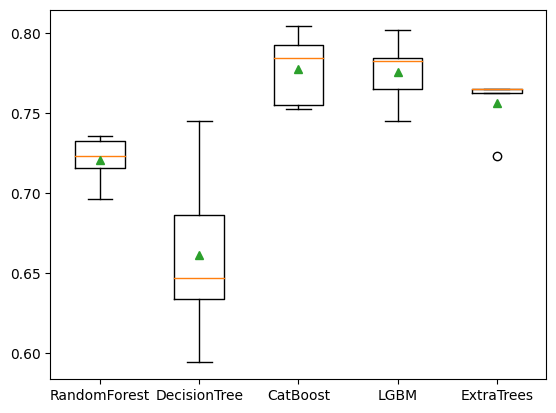

In [40]:
plt.boxplot(models_scores_results, labels=models_names, showmeans=True)
plt.show()

# 밑의 식 같은 경우는 5가지의 조합을 해봤을때의 결과값을 출력해보는 코드인데 
# 하루 종일 돌려도 결과값이 다 안나와서 돌리다가 포기했습니다
# 결과값: (제가 사진 올려드릴게요)  시간나면 돌려보겠습니다 
# Total number of model combination: 26
  1 - Stacked combination - Acc ('RandomForest', 'DecisionTree'): 0.73233
  2 - Stacked combination - Acc ('RandomForest', 'CatBoost'): 0.74351
  3 - Stacked combination - Acc ('RandomForest', 'LGBM'): 0.72863
  4 - Stacked combination - Acc ('RandomForest', 'ExtraTrees'): 0.73607
  5 - Stacked combination - Acc ('DecisionTree', 'CatBoost'): 0.73420
  6 - Stacked combination - Acc ('DecisionTree', 'LGBM'): 0.73981
  7 - Stacked combination - Acc ('DecisionTree', 'ExtraTrees'): 0.73046
  8 - Stacked combination - Acc ('CatBoost', 'LGBM'): 0.73233
  9 - Stacked combination - Acc ('CatBoost', 'ExtraTrees'): 0.73046
  10 - Stacked combination - Acc ('LGBM', 'ExtraTrees'): 0.73794
  11 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'CatBoost'): 0.78626
  12 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'LGBM'): 0.78998
  13 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'ExtraTrees'): 0.78811
  14 - Stacked combination - Acc ('RandomForest', 'CatBoost', 'LGBM'): 0.78813
  15 - Stacked combination - Acc ('RandomForest', 'CatBoost', 'ExtraTrees'): 0.78439
  16 - Stacked combination - Acc ('RandomForest', 'LGBM', 'ExtraTrees'): 0.79185
  17 - Stacked combination - Acc ('DecisionTree', 'CatBoost', 'LGBM'): 0.79000

In [42]:
taken_classifiers = ["RandomForest", "DecisionTree", "CatBoost", "LGBM", "ExtraTrees"]

In [43]:
def best_stacking_search():
    cls_list = []
    best_auc = -1
    i=0

    best_cls_experiment = list()

    print(">>>> Training started <<<<")

    for cls_comb in range(2, len(taken_classifiers)+1):
        for subset in itertools.combinations(taken_classifiers, cls_comb):
            cls_list.append(subset)

    print(f"Total number of model combination: {len(cls_list)}")

    for cls_exp in cls_list:
        cls_labels = list(cls_exp)

        classifier_exp = []
        for ii in range(len(cls_labels)):
            label = taken_classifiers[ii]
            classifier = classifiers[label]
            classifier_exp.append(classifier)

        sclf = StackingCVClassifier(classifiers = classifier_exp,
                                    shuffle = False,
                                    use_probas = True,
                                    cv = FOLDS,
                                    meta_classifier = mlr,
                                    n_jobs = -1)

        scores = cross_val_score(sclf, X_train, y_train, cv = FOLDS, scoring='accuracy')

        if scores.mean() > best_auc:
            best_cls_experiment = list(cls_exp)
        i += 1
        print(f"  {i} - Stacked combination - Acc {cls_exp}: {scores.mean():.5f}")
        
    return best_cls_experiment

In [44]:
# pip install mlxtend

In [45]:
# !pip install eli5

In [46]:
import eli5
from eli5.sklearn import PermutationImportance

# 밑의 permutationImportances는 각 모델이 중요하게 살펴보는 지표를 알려주는데 +에서 부터 -까지 나타나있습니다 
# -같은경우는 결과값에 방해를 주기 때문에, 제외하고 너무 많은 column들을 지우게 되다보면 결과값에 영향을 미치게 되어서 0으로 나오는 column들도 포함할수 있도록 기준은 -0.001로 잡았습니다

In [48]:
model=CatBoostClassifier(silent=True, random_state=37).fit(X_train, y_train)

In [49]:
perm = PermutationImportance(model, random_state=37).fit(X_test, y_test)


In [50]:
minimum_importance = -0.001
mask = perm.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]

# 돌려봤을때'LGBM',"DecisionTree",'CatBoost' 의 결과값이 좋았고 이를 이용해서 StackingCVClassifier로 파라미터 찾아주면서 가장 적절한 best모델을 top_meta_model이라고 저장합니다.

In [51]:
best_cls_experiment = [ 'LGBM',"DecisionTree",'CatBoost'] 

In [52]:
print(f'The best models configuration: {best_cls_experiment}')

classifier_exp = []
for label in best_cls_experiment:
        classifier = classifiers[label]
        classifier_exp.append(classifier)

The best models configuration: ['LGBM', 'DecisionTree', 'CatBoost']


In [53]:
classifier_exp

[LGBMClassifier(),
 DecisionTreeClassifier(),

In [54]:
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = 37)

scores = cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)

top_meta_model = scl
base_acc = scores.mean()
# Meta model (slc) - accuracy: 0.78938 

Meta model (slc) - accuracy: 0.77754 


In [62]:
def meta_best_params_search():

    scl_params = {'meta_classifier__C': [0.001,0.01, 0.1, 1, 10, 14, 16]}

    print(">>>> Searching for best parameters started <<<<")

    grid = GridSearchCV(estimator=scl, 
                        param_grid= scl_params, 
                        cv=5,
                        refit=True)
    grid.fit(X_train, y_train)

    cv_keys = ('mean_test_score', 'std_test_score', 'params')

    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        print("%0.3f +/- %0.2f %r" % (grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r] / 2.0, grid.cv_results_[cv_keys[2]][r]))

    print('Best parameters: %s' % grid.best_params_)
    print('Accuracy: %.5f' % grid.best_score_)
    return grid, grid.best_score_

In [63]:
hyper_meta_model, hyper_acc = meta_best_params_search()

>>>> Searching for best parameters started <<<<
0.675 +/- 0.00 {'meta_classifier__C': 0.001}
0.675 +/- 0.00 {'meta_classifier__C': 0.01}
0.772 +/- 0.01 {'meta_classifier__C': 0.1}
0.793 +/- 0.01 {'meta_classifier__C': 1}
0.783 +/- 0.01 {'meta_classifier__C': 10}
0.789 +/- 0.01 {'meta_classifier__C': 14}
0.776 +/- 0.01 {'meta_classifier__C': 16}
Best parameters: {'meta_classifier__C': 1}
Accuracy: 0.79334


In [80]:
hyper_meta_model.best_params_

{'meta_classifier__C': 1}

In [82]:
len(features)

2801

In [84]:
len(train_x.columns)

2877

In [75]:
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = 37)

scores =cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(train_x[features], train_y)

top_meta_model = scl
base_acc = scores.mean()

Meta model (slc) - accuracy: 0.78348 


# 이제 predict를 해줍니다 

In [76]:
#top_meta_model = hyper_meta_model
classifiers["scl"] = top_meta_model

In [77]:

test_x = test_x[features]
test_preds = classifiers['scl'].predict(test_x)[:,]

In [78]:
submission = pd.read_csv('./sample_submission.csv')
submission['Y_Class'] = test_preds
submission['Y_Class'].value_counts()


1    261
0     40
2      9
Name: Y_Class, dtype: int64

In [68]:
submission.to_csv('./extralgbmcatBoost_remove_test1.csv', index=False)


In [ ]:
# 1    265
# 0     38
# 2      7
# Name: Y_Class, dtype: int64

1    265
0     38
2      7
Name: Y_Class, dtype: int64